In [2]:
import openeo
import xarray
import matplotlib.pyplot as plt

In [3]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection

<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with NullAuth>

In [4]:
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [5]:
coords = {
    "west": 21.04,  # Zmodyfikowane współrzędne
    "south": 52.13,
    "east": 21.07,
    "north": 52.15
}

In [6]:
s2_cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=("2024-07-01", "2024-08-01"),  # Zamiast zakresu, podaj konkretny dzień
    spatial_extent={
        **coords,
        "crs": "EPSG:4326",
    },
    bands=["B08", "B11"],
    max_cloud_cover=20,
)

In [7]:
s2_cube.download("load-raw.nc")

In [8]:
# Wczytaj dane z pliku

ds = xarray.load_dataset("load-raw.nc")


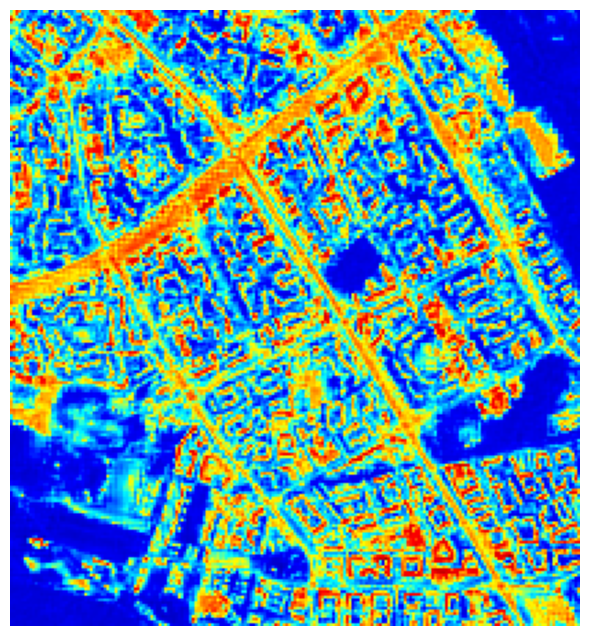

In [9]:

from matplotlib.colors import LinearSegmentedColormap

import numpy as np
# Oblicz NDMI
ds['NDMI'] = (ds['B08'] - ds['B11']) / (ds['B08'] + ds['B11'])

# Konwertuj DataSet na DataArray (bands, t, x, y)
data = ds[["NDMI"]].to_array(dim="bands")

# Definiujemy wartości NDMI i odpowiadające im kolory w formacie RGB
# Przeskalowujemy wartości na przedział [0, 1], który jest wymagany przez LinearSegmentedColormap
moisture_ramps = [
    (-0.8, '#800000'),  # ciemnoczerwony
    (-0.24, '#ff0000'),  # czerwony
    (-0.032, '#ffff00'),  # żółty
    (0.032, '#00ffff'),  # cyjan
    (0.24, '#0000ff'),  # niebieski
    (0.8, '#000080')    # ciemnoniebieski
]

# Tworzymy dostosowaną mapę kolorów
colors = [color for _, color in moisture_ramps]
positions = [(val + 0.8) / 1.6 for val, _ in moisture_ramps]  # Przeskalowujemy wartości NDMI na zakres [0, 1]

cmap = LinearSegmentedColormap.from_list("custom_moisture_cmap", list(zip(positions, colors)))



# Wyciągnięcie danych NDMI dla pierwszego dnia
ndmi_data = data.isel(bands=0, t=0).values  # Wartości NDMI dla pierwszego dnia

# Znormalizowanie danych do zakresu [0, 1]
ndmi_data_normalized = (ndmi_data + 0.8) / 1.6  # Przekształcamy na zakres [0, 1]

# Zastosowanie cmap do uzyskania kolorów
colored_image = (cmap(ndmi_data_normalized)[:, :, :3] * 255).astype(np.uint8)  # RGB
alpha_channel = np.ones((colored_image.shape[0], colored_image.shape[1], 1), dtype=np.uint8) * 255  # Pełna nieprzezroczystość
rgba_image = np.concatenate((colored_image, alpha_channel), axis=2)  # Łączymy RGB z alpha

# Tworzenie obrazu
image = Image.fromarray(rgba_image, mode='RGBA')

# Zapisanie obrazu do pliku PNG
image.save("maps/ndmi_streets_clean.png")

from PIL import Image
import matplotlib.pyplot as plt

# Wczytanie obrazu
image_path = "maps/ndmi_streets_clean.png"
img = Image.open(image_path)

# Wyświetlenie obrazu w Jupyter Notebook
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # Ukrycie osi
plt.show()

Width: 207, Height: 224


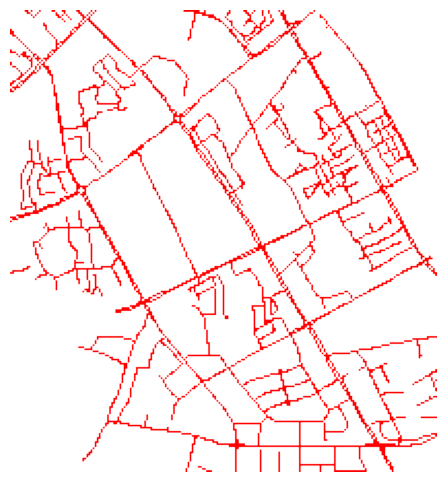

In [10]:
import os
import numpy as np
import geopandas as gpd
import osmnx as ox
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


# Wczytanie obrazu
image_path = "maps/ndmi_streets_clean.png"
img = Image.open(image_path)

# Sprawdzenie wymiarów obrazu
width, height = img.size
print(f"Width: {width}, Height: {height}")

# Definicja miejsca: Ursynów, Warszawa, Polska
place_name = "Ursynow, Warsaw, Poland"

# Pobranie grafu ulicznego dla Ursynowa
G = ox.graph_from_place(place_name, network_type='drive')

# Pobranie krawędzi (ulic) z grafu
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Ustawienia obrazu
#width, height = 500, 500  # Rozmiar obrazu
background_color = (255, 255, 255, 0)  # Przezroczyste tło
line_color = (255, 0, 0, 255)  # Czerwony kolor linii z pełną nieprzezroczystością

# Tworzenie nowego obrazu z przezroczystym tłem (RGBA)
image = Image.new("RGBA", (width, height), background_color)
draw = ImageDraw.Draw(image)

# Ustawienia granic geograficznych dla Ursynowa
lon_min, lon_max = coords["west"], coords["east"]
lat_min, lat_max = coords["south"], coords["north"]

# Funkcja do konwersji współrzędnych geograficznych na piksele
def geo_to_pixel(lon, lat, width, height, lon_min, lon_max, lat_min, lat_max):
    x = int((lon - lon_min) / (lon_max - lon_min) * width)
    y = height - int((lat - lat_min) / (lat_max - lat_min) * height)  # Inwersja osi y
    return x, y

# Rysowanie ulic na obrazie
for _, row in edges.iterrows():
    coords = row['geometry'].coords
    for i in range(len(coords) - 1):
        x1, y1 = geo_to_pixel(coords[i][0], coords[i][1], width, height, lon_min, lon_max, lat_min, lat_max)
        x2, y2 = geo_to_pixel(coords[i + 1][0], coords[i + 1][1], width, height, lon_min, lon_max, lat_min, lat_max)
        draw.line((x1, y1, x2, y2), fill=line_color, width=1)

# Zapisanie obrazu do pliku PNG z przezroczystym tłem
os.makedirs("maps", exist_ok=True)
image_path = "maps/kabaty_streets_pixelated_transparent.png"
image.save(image_path, "PNG")

# Wyświetlenie obrazu w Jupyter Notebook
img = Image.open(image_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')  # Ukrycie osi
plt.show()


Width: 207, Height: 224


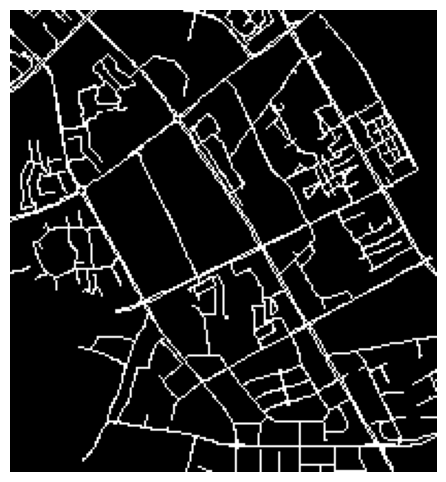

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])


In [11]:
import os
import numpy as np
import geopandas as gpd
import osmnx as ox
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch

# Wczytanie obrazu
image_path = "maps/kabaty_streets_pixelated_transparent.png"
img = Image.open(image_path).convert("RGBA")  # Upewnij się, że obraz ma kanał alpha

# Sprawdzenie wymiarów obrazu
width, height = img.size
print(f"Width: {width}, Height: {height}")

# Tworzenie macierzy numpy
data = np.array(img)

# Tworzenie macierzy boolowskiej
# Czerwony kolor w RGBA to (255, 0, 0, 255)
# Przezroczysty kolor to (255, 255, 255, 0) lub (0, 0, 0, 0)
red_pixels = (data[:, :, 0] == 255) & (data[:, :, 1] == 0) & (data[:, :, 2] == 0) & (data[:, :, 3] == 255)
transparent_pixels = (data[:, :, 3] == 0)

# Stworzenie macierzy boolowskiej (1 dla czerwonych pikseli, 0 dla przezroczystych)
bool_array = np.zeros((height, width), dtype=np.bool_)
bool_array[red_pixels] = 1  # Ustawienie czerwonych pikseli na 1

# Konwersja na tensor PyTorch
torch_tensor = torch.tensor(bool_array, dtype=torch.bool)

# Zapisanie macierzy numpy jako plik .npy (opcjonalne)
np.save("maps/kabaty_streets_bool_array.npy", bool_array)

# Wyświetlenie obrazu w Jupyter Notebook
plt.figure(figsize=(6, 6))
plt.imshow(bool_array, cmap='gray')  # Użyj szarości dla wyświetlenia
plt.axis('off')  # Ukrycie osi
plt.show()

# Wydrukowanie tensoru PyTorch
print(torch_tensor)


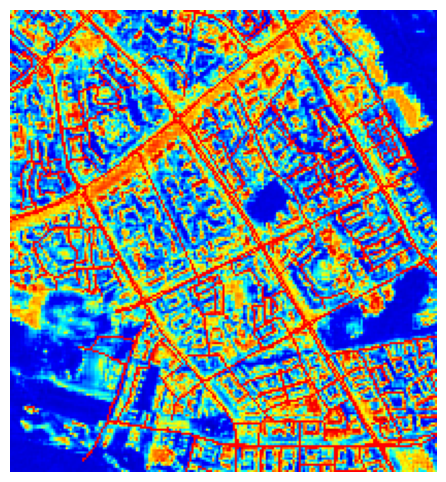

In [12]:
from PIL import Image

# Wczytanie obrazów
background = Image.open("maps/ndmi_streets_clean.png")
overlay = Image.open("maps/kabaty_streets_pixelated_transparent.png")

# Upewnij się, że oba obrazy mają ten sam rozmiar
if background.size != overlay.size:
    overlay = overlay.resize(background.size)  # Zmiana rozmiaru overlay, jeśli to konieczne

# Nałożenie overlay na background
# Ostatni argument 'overlay' to maska alpha, która pozwala zachować przezroczystość
background.paste(overlay, (0, 0), overlay)

# Zapisanie wyniku
background.save("maps/combined_image.png")


# Wyświetlenie obrazu w Jupyter Notebook
img = Image.open("maps/combined_image.png")
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')  # Ukrycie osi
plt.show()


In [13]:
import os
import numpy as np
import geopandas as gpd
import osmnx as ox
from PIL import Image
import matplotlib.pyplot as plt
import torch
from matplotlib.colors import LinearSegmentedColormap

# Oblicz NDMI
ds['NDMI'] = (ds['B08'] - ds['B11']) / (ds['B08'] + ds['B11'])

# Konwertuj DataSet na DataArray (bands, t, x, y)
data = ds[["NDMI"]].to_array(dim="bands")

# Wyciągnięcie danych NDMI dla pierwszego dnia
ndmi_data = data.isel(bands=0, t=0).values  # Wartości NDMI dla pierwszego dnia
ndmi_tensor = torch.tensor(ndmi_data, dtype=torch.float32)

# Znormalizowanie danych do zakresu [0, 1]
min_ndmi = torch.min(ndmi_tensor)
max_ndmi = torch.max(ndmi_tensor)
# Przekształcenie danych NDMI na zakres [1, 0.1]
ndmi_data_normalized = ((ndmi_tensor.numpy() - min_ndmi.numpy()) * 0.9) / (max_ndmi.numpy() - min_ndmi.numpy()) + 0.1

# Tworzenie macierzy NDMI jako tensor PyTorch z znormalizowanych danych
ndmi_tensor = torch.tensor(ndmi_data_normalized, dtype=torch.float32)


# Wczytanie obrazu z ulicami
streets_image_path = "maps/kabaty_streets_pixelated_transparent.png"
streets_img = Image.open(streets_image_path).convert("RGBA")

# Sprawdzenie wymiarów obrazu z ulicami
streets_data = np.array(streets_img)

# Tworzenie maski dla czerwonych pikseli
red_pixels = (streets_data[:, :, 0] == 255) & (streets_data[:, :, 1] == 0) & (streets_data[:, :, 2] == 0) & (streets_data[:, :, 3] == 255)
mask = np.zeros(ndmi_tensor.shape, dtype=np.bool_)
mask[red_pixels] = 1  # Ustawienie czerwonych pikseli na 1

# Stworzenie macierzy NDMI z maską
masked_ndmi = ndmi_tensor * torch.tensor(mask, dtype=torch.float32)  # Nakładanie maski

# Zapisanie macierzy NDMI jako plik .npy (opcjonalne)
np.save("maps/masked_ndmi.npy", masked_ndmi.numpy())

# Wyświetlenie wynikowej macierzy NDMI w Jupyter Notebook
plt.figure(figsize=(8, 8))
plt.imshow(masked_ndmi.numpy(), cmap='gray')  # Użyj szarości dla wyświetlenia
plt.axis('off')  # Ukrycie osi
plt.show()

# Wydrukowanie tensoru PyTorch
print(masked_ndmi)


TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'